In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!7z x /content/drive/MyDrive/herbarium-2020-fgvc7-small.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 17022229754 bytes (16 GiB)

Extracting archive: /content/drive/MyDrive/herbarium-2020-fgvc7-small.zip
  1% 4096 Open                8% 28672 Open                21% 69632 Open                54% 180224 Open                --
Path = /content/drive/MyDrive/herbarium-2020-fgvc7-small.zip
Type = zip
Physical Size = 17022229754
64-bit = +

  0%      0% 8 - herbarium-2020-fgvc7-small/nybg2020/train/metadata.json                            

In [ ]:
import os

os.system('rm -r herbarium2020-kaggle')
os.system('git clone https://github.com/aamster/herbarium2020-kaggle.git')
os.system('pip install mlflow boto3')

0

In [ ]:
import sys

sys.path.append('herbarium2020-kaggle/')

In [ ]:
os.environ["AWS_ACCESS_KEY_ID"] = input()
os.environ['AWS_SECRET_ACCESS_KEY'] = input()

In [ ]:
from HerbariumDataset import HerbariumDataset
from Transforms import CropBorder
from DataLoader import TrainDataLoader
from HerbariumClassifier import Classifier
from util import split_image_metadata
from mlflow_util import load_model_from_checkpoint
from Metrics import Metrics

import pandas as pd
from pathlib import Path
import torchvision
from torch import nn
import torch
import torchvision.transforms as transforms
import json
import mlflow
import numpy as np
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
import seaborn as sns

In [ ]:
sns.set_style('darkgrid')

In [ ]:
mlflow.set_tracking_uri(input())

In [ ]:
def plot_train_val_loss():
  experiment = mlflow.get_experiment_by_name('baseline')
  df = mlflow.search_runs([experiment.experiment_id])
  run_id = df.iloc[0]['run_id']

  client = MlflowClient()

  train_loss_hist = client.get_metric_history(run_id, 'train loss')
  val_loss_hist = client.get_metric_history(run_id, 'val loss')

  
  train_losses = [{'epoch': x.step, 'train loss': x.value} 
                   for x in train_loss_hist]
  train_losses = pd.DataFrame(train_losses).set_index('epoch')
  val_losses = [{'epoch': x.step, 'val loss': x.value} 
                   for x in val_loss_hist]
  val_losses = pd.DataFrame(val_losses).set_index('epoch')

  df = pd.DataFrame({'train loss': train_losses['train loss'], 
                     'val loss': val_losses['val loss']})
  
  f, ax = plt.subplots(figsize=(5, 2.5))
  ax.set_title('Training Loss')
  ax.set_ylabel('Loss')
  sns.lineplot(data=df, markers=['o', 'o'], dashes=False)
  plt.tight_layout()

In [ ]:
def plot_val_f1():
  experiment = mlflow.get_experiment_by_name('baseline')
  df = mlflow.search_runs([experiment.experiment_id])
  run_id = df.iloc[0]['run_id']

  client = MlflowClient()

  val_f1_hist = client.get_metric_history(run_id, 'val F1')
  
  val_f1s = [{'epoch': x.step, 'val F1': x.value} 
                   for x in val_f1_hist]
  val_f1s = pd.DataFrame(val_f1s).set_index('epoch')

  df = pd.DataFrame({'val F1': val_f1s['val F1']})
  
  f, ax = plt.subplots(figsize=(5, 2.5))
  ax.set_title('Validation F1')
  ax.set_ylabel('F1')
  sns.lineplot(data=df, markers=['o'], dashes=False)
  plt.tight_layout()

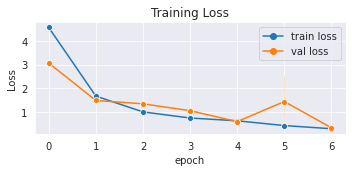

In [ ]:
plot_train_val_loss()
plt.savefig('loss.png', dpi=600)

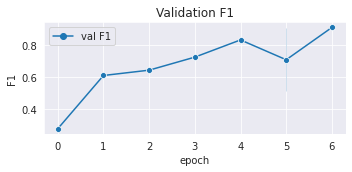

In [ ]:
plot_val_f1()
plt.savefig('f1.png', dpi=600)

In [ ]:
with open('herbarium-2020-fgvc7-small/nybg2020/train/metadata.json', encoding='latin-1') as f:
    metadata = json.loads(f.read())
    
annotations = pd.DataFrame(metadata['annotations'])
annotations = annotations.drop(['id'], axis=1)
annotations.to_csv('annotations.csv', index=False)

images = pd.DataFrame(metadata['images'])

In [ ]:
def filter_top_categories(annotations, images):
    """
    Filters possible images to only top 1000 categories
    """
    keep_cats = pd.read_csv('keep_cats.csv')['category_id']
    keep_ann = annotations[annotations['category_id'].isin(keep_cats)]
    keep_ann.to_csv('annotations.csv', index=False)

    keep_img_ids = keep_ann['image_id']
    keep_imgs = images[images['id'].isin(keep_img_ids)]
    keep_imgs.to_csv('images.csv', index=False)
    print(f'keep {keep_imgs.shape[0]} imgs')

In [ ]:
filter_top_categories(annotations=annotations, images=images)

keep 328956 imgs


In [ ]:
np.random.seed(1234)

In [ ]:
train_images, val_images, test_images = split_image_metadata(path='images.csv', train_frac=.7)
train_images.to_csv('train_images.csv', index=False)
val_images.to_csv('valid_images.csv', index=False)
test_images.to_csv('test_images.csv', index=False)

# Test set performance

In [ ]:
test_transform = transforms.Compose([
    CropBorder(),
    transforms.ToTensor(),
    transforms.Resize((448, 314)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_data = HerbariumDataset(
    annotations_file='annotations.csv',
                              image_metadata_file='test_images.csv',
                              img_dir='herbarium-2020-fgvc7-small/nybg2020/train/', 
    transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=32,
                                           num_workers=2)

In [ ]:
classifier = Classifier(load_model_from_checkpoint=True, artifact_path='model',
                        n_epochs=100, experiment_name='baseline')
test_metrics = classifier.predict(valid_loader=test_loader)
test_metrics.macro_f1

INFO:	05/30/2021 10:55:08 PM	Found credentials in environment variables.


KeyboardInterrupt: ignored

# Per class stats

In [ ]:
valid_transform = transforms.Compose([
    CropBorder(),
    transforms.ToTensor(),
    transforms.Resize((448, 314)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

valid_data = HerbariumDataset(
    annotations_file='annotations.csv',
                              image_metadata_file='valid_images.csv',
                              img_dir='herbarium-2020-fgvc7-small/nybg2020/train/', 
    transform=valid_transform)

valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=32,
                                           num_workers=2)

In [ ]:
classifier = Classifier(load_model_from_checkpoint=True, artifact_path='model',
                        n_epochs=100, experiment_name='baseline')

INFO:	06/01/2021 03:11:03 AM	Found credentials in environment variables.


In [ ]:
valid_metrics = classifier.predict(valid_loader=valid_loader, 
                                   return_confusion_matrix=True)

Val: 100%|██████████| 1542/1542 [18:00<00:00,  1.43it/s]


In [ ]:
per_class_stats = valid_metrics.per_class_stats

INFO:	05/30/2021 11:13:41 PM	NumExpr defaulting to 2 threads.


In [ ]:
display(per_class_stats.sort_values('f1'))
per_class_stats.to_csv('per_class_stats.csv')

,precision,recall,f1,n
687,0.636364,0.280000,0.388889,25
45,0.342105,0.650000,0.448276,20
330,0.592593,0.581818,0.587156,55
376,0.735294,0.510204,0.602410,49
686,0.650000,0.565217,0.604651,46
...,...,...,...,...
827,1.000000,1.000000,1.000000,36
838,1.000000,1.000000,1.000000,35
902,1.000000,1.000000,1.000000,30
477,1.000000,1.000000,1.000000,21


In [ ]:
def plot_f1_distr():
  per_class_stats = pd.read_csv('per_class_stats.csv')
  f, ax = plt.subplots(figsize=(5, 2.5))
  sns.histplot(data=per_class_stats, x='f1')
  ax.set_title('F1 distribution (validation)')
  plt.tight_layout()
  plt.savefig('f1_distribution.png', dpi=600)

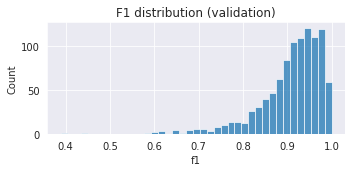

In [ ]:
plot_f1_distr()

# KNN on feature vectors

In [ ]:
valid_transform = transforms.Compose([
    CropBorder(),
    transforms.ToTensor(),
    transforms.Resize((448, 314)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

valid_data = HerbariumDataset(
    annotations_file='annotations.csv',
                              image_metadata_file='valid_images.csv',
                              img_dir='herbarium-2020-fgvc7-small/nybg2020/train/', 
    transform=valid_transform)

valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=32,
                                           num_workers=2)

In [ ]:
classifier = Classifier(load_model_from_checkpoint=True, artifact_path='model',
                        n_epochs=100, experiment_name='baseline')

INFO:	06/01/2021 01:14:38 PM	Found credentials in environment variables.


In [ ]:
activations = classifier.get_last_layer_features(valid_loader=valid_loader)

Val: 100%|██████████| 1542/1542 [18:35<00:00,  1.38it/s]


In [ ]:
def knn(category_id, activations: torch.Tensor, k=5, only_misclassified=True,
        val_metrics: Metrics = None):
  images = valid_data.image_metadata
  annotations = valid_data.annotations
  df = images.merge(annotations, left_index=True, right_index=True)
  image_id = df[df['category_id'] == category_id].sample().index[0]
  idx = np.where(images.index == image_id)[0][0]
  image_activations = activations[idx]
  l2 = torch.sqrt(torch.sum(((image_activations - activations)**2), dim=1))
  neighbors = torch.argsort(l2)

  if only_misclassified:
    y_trues = np.array(val_metrics.y_trues)
    y_preds = np.array(val_metrics.y_preds)

    y_trues = y_trues[neighbors]
    y_preds = y_preds[neighbors]
    
    misclassified = (y_trues == category_id) & (y_preds != y_trues)
    neighbors = neighbors[misclassified | (neighbors == idx)]
  neighbors = neighbors[:k]
  return neighbors
  

In [ ]:
def plot_knn(category_id, activations: torch.Tensor, cid_map, categories,
             k=5, val_metrics: Metrics = None, only_misclassified=False):
  nearest_neighbors = knn(category_id=category_id, activations=activations, k=k,
                          val_metrics=val_metrics, only_misclassified=only_misclassified)

  valid_transform = transforms.Compose([
      CropBorder(),
      transforms.ToPILImage(),
      transforms.Resize((448, 314))
  ])

  valid_data = HerbariumDataset(
      annotations_file='annotations.csv',
                                image_metadata_file='valid_images.csv',
                                img_dir='herbarium-2020-fgvc7-small/nybg2020/train/', 
      transform=valid_transform)

  f, ax = plt.subplots(nrows=1, ncols=k, figsize=(16, 4))
  for i, idx in enumerate(nearest_neighbors):
    idx = idx.item()
    image_id = valid_data.image_metadata.iloc[idx].name
    cid = valid_data.annotations.loc[image_id, 'category_id']

    family = categories.loc[cid_map[cid]]['family']
    genus = categories.loc[cid_map[cid]]['genus']
    species = categories.loc[cid_map[cid]]['name']
    
    title = f'Family: {family}\nGenus: {genus}\nSpecies: {species}'
    ax[i].set_title(title, fontsize=8)
    ax[i].imshow(valid_data[idx]['image'])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
  # plt.tight_layout()

  return nearest_neighbors

In [ ]:
def get_cid_map(annotations_file):
    annotations = pd.read_csv(annotations_file).set_index('image_id')
    cur_ids = np.sort(annotations['category_id'].unique())
    new_ids = range(annotations.shape[0])
    map = {new_ids[i]: cur_ids[i] for i in range(len(cur_ids))}
    return map

In [ ]:
cid_map = get_cid_map(annotations_file='annotations.csv')

In [ ]:
categories = pd.DataFrame(metadata['categories']).set_index('id')

tensor([32230,   829, 35907, 29517,  7025])


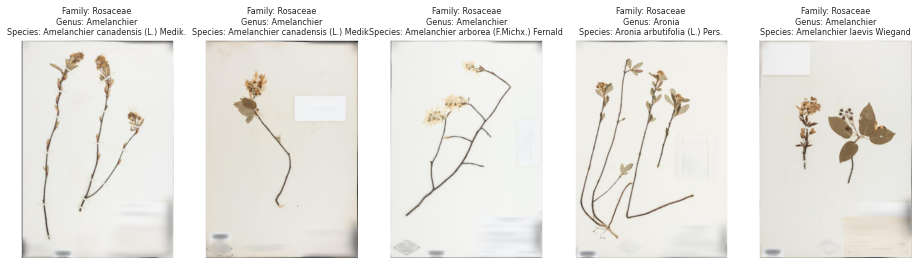

In [ ]:
nearest_neighbors = plot_knn(category_id=45, activations=activations, 
                             cid_map=cid_map, categories=categories, only_misclassified=False)
print(nearest_neighbors)
plt.savefig('knn.png', dpi=600)

tensor([48421, 20007, 38497, 25383,  2854])


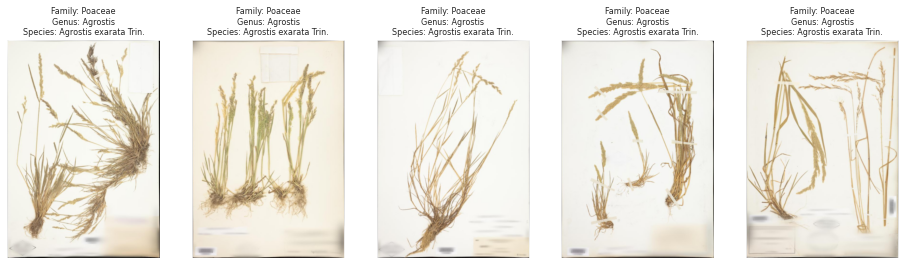

In [ ]:
nearest_neighbors = plot_knn(category_id=28, activations=activations, 
                             cid_map=cid_map, categories=categories)
print(nearest_neighbors)
plt.savefig('knn_good.png', dpi=600)

In [ ]:
def get_top_3_scores(idxs):
  imgs = torch.stack([valid_data[idx]['image'] for idx in idxs])
  imgs = imgs.cuda()
  scores = classifier._model(imgs)
  softmax = torch.nn.Softmax(dim=1)
  scores = softmax(scores)
  top_3 = torch.argsort(-scores, dim=1)[:, :3]

  for i, catids in enumerate(top_3):
    print(catids, top_3[i, catids])

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = True
get_top_3_scores(idxs=[13503, 24517,  5931, 34278, 45031])

TypeError: ignored

# Confusion matrix

In [ ]:
valid_transform = transforms.Compose([
    CropBorder(),
    transforms.ToTensor(),
    transforms.Resize((448, 314)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

valid_data = HerbariumDataset(
    annotations_file='annotations.csv',
                              image_metadata_file='valid_images.csv',
                              img_dir='herbarium-2020-fgvc7-small/nybg2020/train/', 
    transform=valid_transform)

valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=32,
                                           num_workers=2)

In [ ]:
classifier = Classifier(load_model_from_checkpoint=True, artifact_path='model',
                        n_epochs=100, experiment_name='baseline')

In [ ]:
val_metrics = classifier.predict(valid_loader=valid_loader, return_confusion_matrix=True)

Val: 100%|██████████| 1542/1542 [18:05<00:00,  1.42it/s]


In [ ]:
normalized_c_matrix = val_metrics.confusion_matrix / val_metrics.confusion_matrix.sum(dim=1).reshape(-1, 1)

In [ ]:
torch.argsort(-normalized_c_matrix[689])[:3]

tensor([690, 691, 688])

In [ ]:
small_c_matrix = torch.zeros((7, 7))
idxs = [410] + list(range(686, 692))
for i, idx in enumerate(idxs):
  small_c_matrix[i] = normalized_c_matrix[idx, idxs]

In [ ]:
normalized_c_matrix[686:692, 686:692]

tensor([[0.5652, 0.0435, 0.0217, 0.0000, 0.0870, 0.1522],
        [0.1200, 0.2800, 0.0000, 0.0000, 0.1600, 0.2800],
        [0.0000, 0.0000, 0.7170, 0.0377, 0.1321, 0.0000],
        [0.0000, 0.0000, 0.0476, 0.7262, 0.0833, 0.0238],
        [0.0184, 0.0123, 0.0245, 0.0000, 0.7914, 0.0429],
        [0.0151, 0.0000, 0.0000, 0.0000, 0.0415, 0.9057]])

In [ ]:
torch.stack([normalized_c_matrix[686:692, 686:692], normalized_c_matrix[410, [686, 687, 688, 689, 690, 691, 410]].reshape(1, -1)])


RuntimeError: ignored

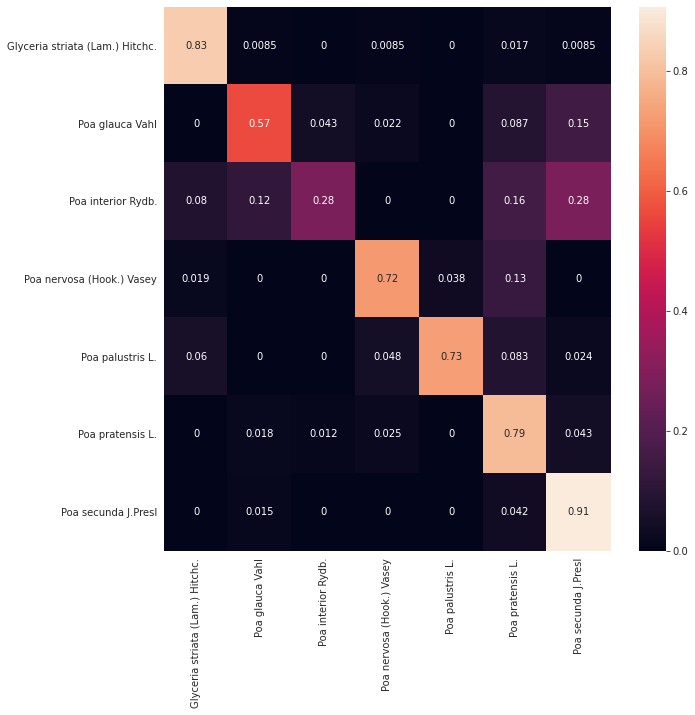

In [ ]:
names = [categories.loc[cid_map[x], 'name'] for x in idxs]
df = pd.DataFrame(small_c_matrix.cpu().numpy(), index=names, 
                  columns=names)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df, annot=True)
plt.savefig('cmatrix.png', dpi=600, bbox_inches='tight')

In [ ]:
[categories.loc[cid_map[x], 'name'] for x in idxs]

['Glyceria striata (Lam.) Hitchc.',
 'Poa glauca Vahl',
 'Poa interior Rydb.',
 'Poa nervosa (Hook.) Vasey',
 'Poa palustris L.',
 'Poa pratensis L.',
 'Poa secunda J.Presl']

In [ ]:
categories.loc[23692]

family            Poaceae
genus                 Poa
id                  23692
name      Poa glauca Vahl
Name: 23692, dtype: object

In [ ]:
categories = pd.DataFrame(metadata['categories'])

In [ ]:
categories[categories['name'] == 'Poa interior Rydb.']

,family,genus,id,name
23696,Poaceae,Poa,23696,Poa interior Rydb.


In [ ]:
[k for k, v in cid_map.items() if v == 23696]

[687]

In [ ]:
def get_preds(category_id):
  pred_counts = valid_metrics.confusion_matrix[category_id]
  pred_counts /= pred_counts.sum()

  top_preds = torch.argsort(pred_counts, descending=True)[:(pred_counts > 0).sum()]

  df = pd.DataFrame({'category_id': top_preds, 'count': pred_counts[top_preds]})
  return df

In [ ]:
get_preds(category_id=376)

,category_id,count
0,376,0.510204
1,375,0.387755
2,374,0.040816
3,786,0.040816
4,899,0.020408


In [ ]:
def show_example_image(category_ids, cid_map):
  valid_data = HerbariumDataset(
      annotations_file='annotations.csv',
                                image_metadata_file='valid_images.csv',
                                img_dir='herbarium-2020-fgvc7-small/nybg2020/train/', 
      transform=None)
  
  f, ax = plt.subplots(nrows=len(category_ids), ncols=3, figsize=(20, 20))

  for i, cid in enumerate(category_ids):
    image_ids = valid_data.annotations[valid_data.annotations['category_id'] == cid].index
    image_idxs = valid_data.image_metadata.reset_index()[valid_data.image_metadata.index.isin(image_ids)].index
    image_idxs = np.random.choice(image_idxs, size=3, replace=False)

    for ii, idx in enumerate(image_idxs):
      sample = valid_data[idx]
    
      ax[i, ii].imshow(sample['image'])
      family = categories.loc[cid_map[cid]]['family']
      genus = categories.loc[cid_map[cid]]['genus']
      species = categories.loc[cid_map[cid]]['name']
      
      title = f'Family: {family}\nGenus: {genus}\nSpecies: {species}'
      ax[i, ii].set_title(title)

In [ ]:
cid_map[691]

23718

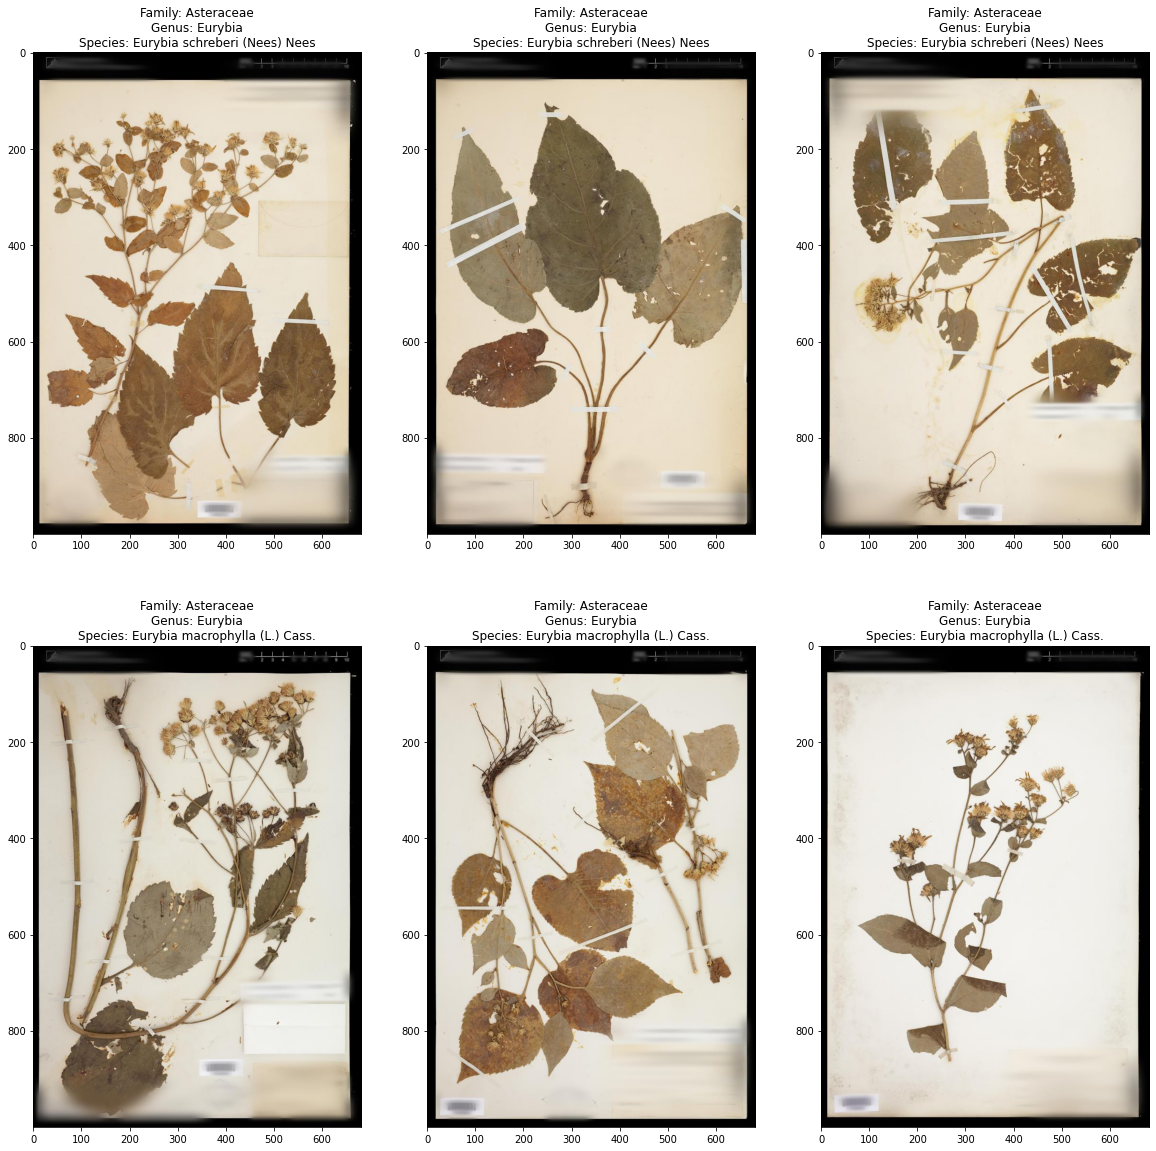

In [ ]:
show_example_image(category_ids=[376, 375], cid_map=cid_map)

In [ ]:
np.where(valid_data.annotations['category_id'] ==)